In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.decomposition import IncrementalPCA as PCA
from numba import jit
import cPickle as pickle

In [5]:
# load the latest, greates PCA                                                                                                                                                     
with open('../table_compression/pca_after_ic59.pkl','rb') as f:                                                                                                                                             
    pca = pickle.load(f)      

In [49]:
# memory map a 5d table
string = 'dc'
depth_idx = 0
table_5d = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_%s_depth_%s/ckv_table.npy'%(string, depth_idx), mmap_mode='r')

In [20]:
reduced_data = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_%s_depth_%s/pca_reduced_table.npy'%(string, depth_idx))

In [21]:
# create 3d table                                                                                                                                                                  
table_3d = np.sum(table_5d, axis=(3,4))                                                                                                                                            
print '3d table created'                                                                                                                                                           
# reject low stats samples (these contian a lot of specific shapes just due to too low statistics. we don't want to add these shapes to our template library)                      
mask = table_3d < 1000.                                                                                                                                                            
print 'mask created'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
length = np.product(table_5d.shape[:3])-np.sum(mask)                                                                                                                                                                                                                                                                                                                  
assert(length == reduced_data.shape[0]), 'data missmatch! %i != %i'%(length,reduced_data.shape[0])                                                                                                                                                                                                                                                                                                            
# compute indices                                                                                                                                                                  
indices = np.empty((length, 3), dtype=np.uint32)                                                                                                                                   
counter = 0                                                                                                                                                                        
for i,m in np.ndenumerate(mask):                                                                                                                                                       
    if not m:                                                                                                                                                                              
        indices[counter] = i                                                                                                                                                               
        counter += 1                        

3d table created
mask created


In [28]:
indices

array([[  0,   0,   0],
       [  0,   1,   0],
       [  0,   2,   0],
       ..., 
       [ 99,  31, 247],
       [ 99,  31, 248],
       [ 99,  31, 249]], dtype=uint32)

In [29]:
restored_data = pca.inverse_transform(reduced_data)

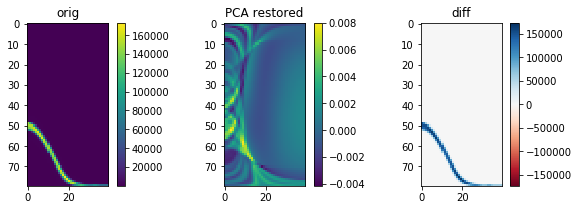

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
n=123
A = table_5d[indices[n][0], indices[n][1], indices[n][2]]
B = restored_data[n].reshape((table_5d.shape[3], table_5d.shape[4]))
im1 = ax1.imshow(A)
cbar = plt.colorbar(im1, ax=ax1)
ax1.set_title('orig')
im2 = ax2.imshow(B)
cbar = plt.colorbar(im2, ax=ax2)
ax2.set_title('PCA restored')
im3 = ax3.imshow(A-B, vmin=-np.max(np.abs(A-B)), vmax=np.max(np.abs(A-B)), cmap='RdBu')
cbar = plt.colorbar(im3, ax=ax3)
ax3.set_title('diff')

In [46]:
# try one by hand
pca_test_d = A.ravel()
pca_test = pca.transform(pca_test_d.reshape(1,-1))
pce_test_restored = pca.inverse_transform(pca_test)

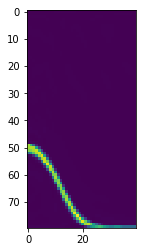

In [48]:
plt.imshow(pce_test_restored.reshape((table_5d.shape[3], table_5d.shape[4])))

In [50]:
templates = np.load('../table_compression/final_templates.npy')

In [52]:
template_map = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_%s_depth_%s/ckv_template_map.npy'%(string, depth_idx))

3273
21752.3007812


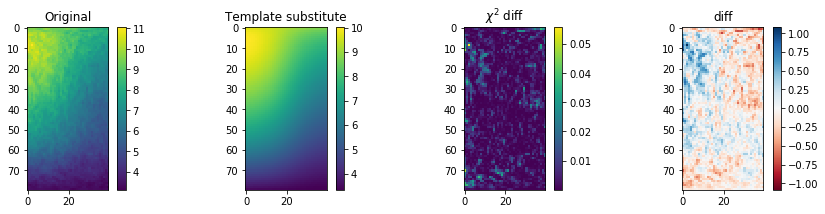

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 3), ncols=4)

r_idx = 9
cz_idx = 20
t_idx = 7

A = table_5d[r_idx, cz_idx, t_idx]
#B = templates[find_best_template(A, templates)]
index, weight = template_map[r_idx, cz_idx, t_idx]
print index
B = templates[index] * weight
print np.sum(B)

im1 = ax1.imshow(A)
cbar = plt.colorbar(im1, ax=ax1)
ax1.set_title('Original')
im2 = ax2.imshow(B)
cbar = plt.colorbar(im2, ax=ax2)
ax2.set_title('Template substitute')
im3 = ax3.imshow(np.square(A-B)/(A+B))
cbar = plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$\chi^2$ diff')
im4 = ax4.imshow(A-B, vmin=-np.max(np.abs(A-B)), vmax=np.max(np.abs(A-B)), cmap='RdBu')
cbar = plt.colorbar(im4, ax=ax4)
ax4.set_title('diff')